In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import sqlite3

import rubin_sim.maf as maf
from rubin_sim.scheduler.utils import SkyAreaGenerator
from rubin_sim.data import get_baseline

In [2]:
# Pick up the "footprint of interest"

nside=64
surveyAreas = SkyAreaGenerator(nside=nside)
map_footprints, map_labels = surveyAreas.return_maps()

In [3]:
# What areas are labelled in the map?
np.unique(map_labels)

array(['', 'LMC_SMC', 'bulge', 'dusty_plane', 'lowdust', 'nes', 'scp',
       'virgo'], dtype='<U20')

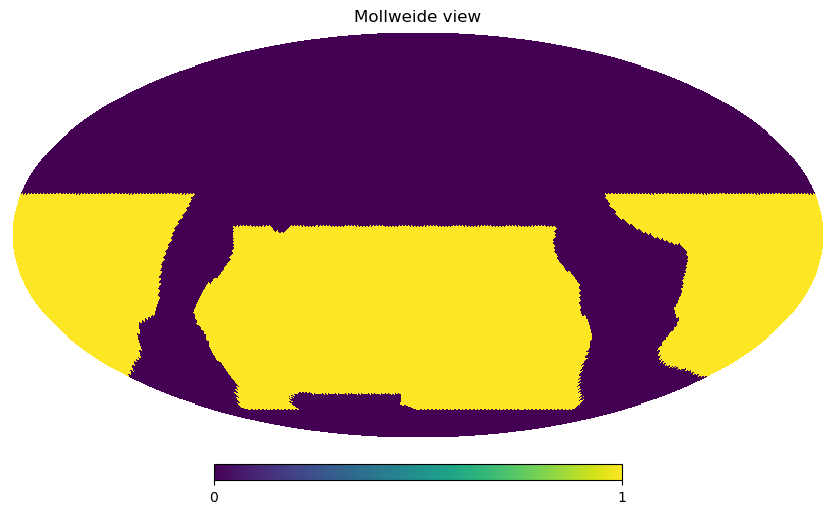

In [4]:
# Let's say the "area of interest" is the low-dust-extinction WFD 
# (note that the bulge and LMC_SMC are also WFD-level in total # of visits)

lowdust = np.where(map_labels == 'lowdust', 1, 0)
hp.mollview(lowdust)

In [5]:
# Let's just connect to the opsim output and check what "notes" are available too 
# We might want to reject or only include some subsets of visits due to survey mode

opsdb = get_baseline()
run_name = os.path.split(opsdb)[-1].replace('.db', '')
print(opsdb, '--', run_name)

/Users/lynnej/rubin_sim_data/sim_baseline/baseline_v3.0_10yrs.db -- baseline_v3.0_10yrs


In [7]:
conn = sqlite3.connect(opsdb)
d = pd.read_sql('select distinct(note) from observations', conn)
conn.close()
d

,note
0,greedy
1,"blob_long, ri, a"
2,"blob_long, ri, b"
3,"blob, yy, a"
4,"blob, yy, b"
5,long
6,twilight_neo
7,"blob_twi, zy, a"
8,"blob_twi, zy, b"
9,"blob_twi, iz, a"


In [14]:
# Let's use these healpixels to calculate our metric -- using a HealpixSubsetSlicer
# Reject DDF and twilight near-sun visits (these are only 15s)

count_metric = maf.CountMetric(col='observationStartMJD', metric_name='NVisits')
depth_metric = maf.Coaddm5Metric()
slicer = maf.HealpixSubsetSlicer(nside=nside, hpid=np.where(map_labels == "lowdust")[0])
constraint = 'note not like "DD%" and note not like "twilight_neo"'

count_bundle = maf.MetricBundle(count_metric, slicer, constraint, run_name=run_name)
depth_bundle = maf.MetricBundle(depth_metric, slicer, constraint + " and filter == 'r'", run_name=run_name)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [15]:
g = maf.MetricBundleGroup({'count': count_bundle, 'depth': depth_bundle}, opsdb, out_dir='tmp_out')

In [16]:
g.run_all()

{'SkyMap': 1, 'Histogram': 2}

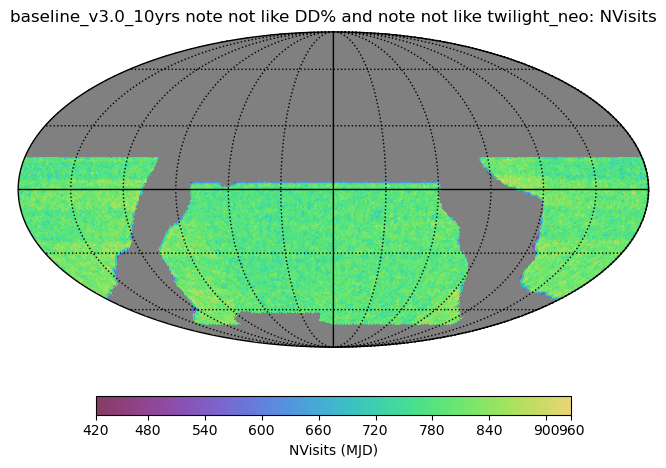

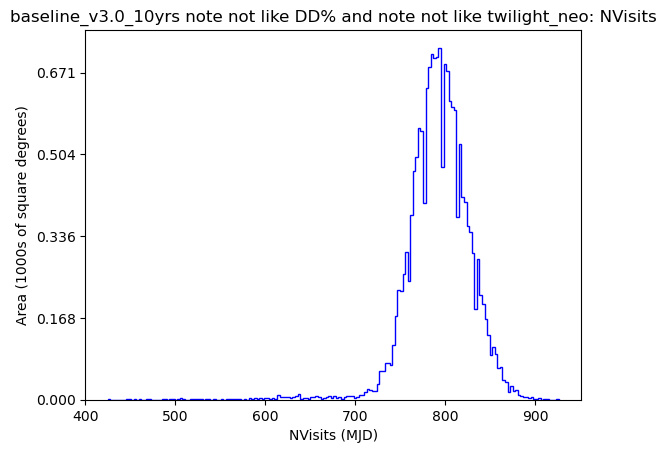

In [17]:
count_bundle.plot()

{'SkyMap': 1, 'Histogram': 2}

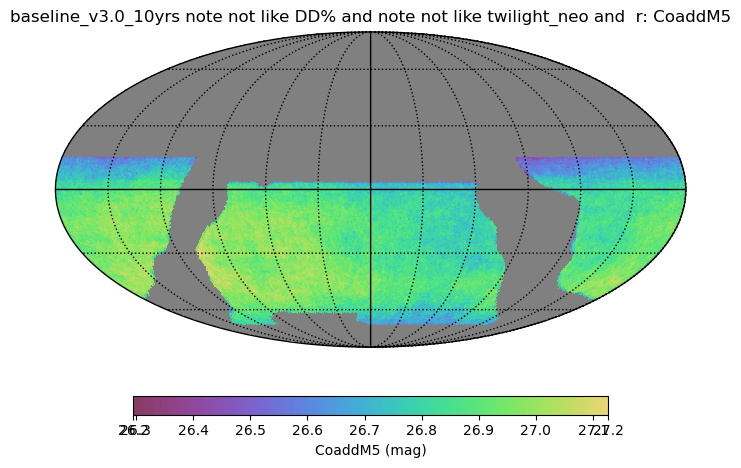

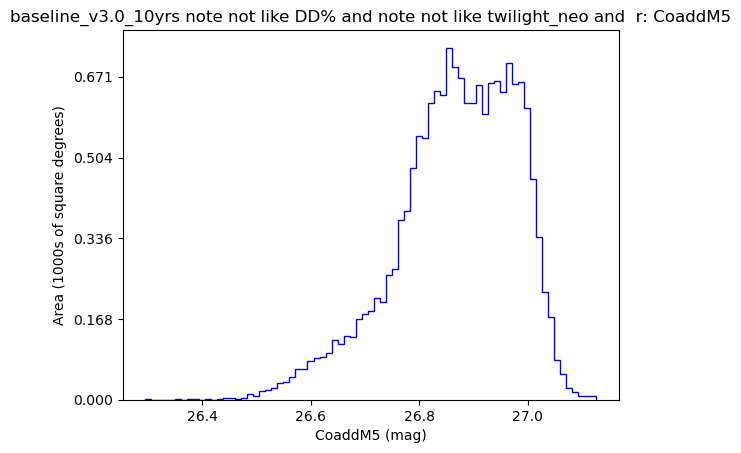

In [18]:
depth_bundle.plot()

In [23]:
count_bundle.set_summary_metrics(maf.extended_summary())
depth_bundle.set_summary_metrics(maf.extended_summary())

count_bundle.compute_summary_stats()
depth_bundle.compute_summary_stats()

In [30]:
pd.DataFrame([count_bundle.summary_values, depth_bundle.summary_values], index=['Count', 'r band depth'])

,Mean,Rms,Median,Max,Min,N(+3Sigma),N(-3Sigma),Count,25th%ile,75th%ile
Count,792.580035,35.232398,793.000000,926.000000,425.000000,11,219,20816,774.000000,813.000000
r band depth,26.867732,0.110566,26.877649,27.126446,26.294928,0,111,20816,26.802751,26.953806
